In [1]:
import os
import time
import argparse

import torchvision
import torch
import torch.nn as nn

from util import AverageMeter, TwoAugUnsupervisedDataset,TwoAugUnsupervisedDatasetSep
from encoder import SmallAlexNet
from align_uniform import align_loss, uniform_loss


def parse_option():
    parser = argparse.ArgumentParser('STL-10 Representation Learning with Alignment and Uniformity Losses')

    parser.add_argument('--align_w', type=float, default=1, help='Alignment loss weight')
    parser.add_argument('--unif_w', type=float, default=1, help='Uniformity loss weight')
    parser.add_argument('--align_alpha', type=float, default=2, help='alpha in alignment loss')
    parser.add_argument('--unif_t', type=float, default=2, help='t in uniformity loss')

    parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
    parser.add_argument('--epochs', type=int, default=200, help='Number of training epochs')
    parser.add_argument('--iter', type=int, default=0, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=None,
                        help='Learning rate. Default is linear scaling 0.12 per 256 batch size')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1, help='Learning rate decay rate')
    parser.add_argument('--lr_decay_epochs', default=[155, 170, 185], nargs='*', type=int,
                        help='When to decay learning rate')
    parser.add_argument('--momentum', type=float, default=0.9, help='SGD momentum')
    parser.add_argument('--weight_decay', type=float, default=1e-4, help='L2 weight decay')
    parser.add_argument('--feat_dim', type=int, default=128, help='Feature dimensionality')

    parser.add_argument('--num_workers', type=int, default=4, help='Number of data loader workers to use')
    parser.add_argument('--log_interval', type=int, default=40, help='Number of iterations between logs')
    parser.add_argument('--gpus', default=[1], nargs='*', type=int,
                        help='List of GPU indices to use, e.g., --gpus 0 1 2 3')

    parser.add_argument('--data_folder', type=str, default='./data', help='Path to data')
    parser.add_argument('--result_folder', type=str, default='./results', help='Base directory to save model')

    opt = parser.parse_args("")

    if opt.lr is None:
        opt.lr = 0.12 * (opt.batch_size / 256)

    opt.gpus = list(map(lambda x: torch.device('cuda', x), opt.gpus))

    opt.save_folder = os.path.join(
        opt.result_folder,
        f"base_ch_resize_transform_align{opt.align_w:g}alpha{opt.align_alpha:g}_unif{opt.unif_w:g}t{opt.unif_t:g}_iter{opt.iter}"
    )
    os.makedirs(opt.save_folder, exist_ok=True)

    return opt


def get_data_loader_1(opt):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2)
    ])

    resize_transform = torchvision.transforms.Compose([  torchvision.transforms.Resize(64),
                                                         torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize(
                                                             (0.44087801806139126, 0.42790631331699347,
                                                              0.3867879370752931),
                                                             (0.26826768628079806, 0.2610450402318512,
                                                              0.26866836876860795),
                                                         )
                                                         ])

    dataset = TwoAugUnsupervisedDatasetSep(
        torchvision.datasets.STL10(opt.data_folder, 'train+unlabeled', download=True), transform=transform, resize_transform=resize_transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, num_workers=opt.num_workers,
                                       shuffle=True, pin_memory=True)



def get_data_loader_2(opt):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ])

    resize_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ])
    dataset = TwoAugUnsupervisedDatasetSep(
        torchvision.datasets.STL10(opt.data_folder, 'train+unlabeled', download=True), resize_transform=resize_transform, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, num_workers=opt.num_workers,
                                       shuffle=True, pin_memory=True)

opt = parse_option()

In [2]:
dataset = torchvision.datasets.STL10(opt.data_folder, 'train+unlabeled', download=True)

Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt

In [4]:
transform1 = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2)
    ])

transform2 = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


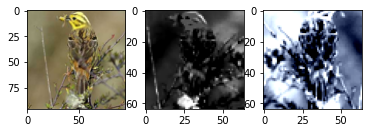

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


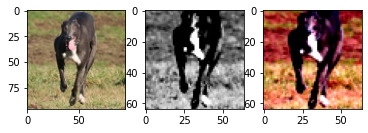

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


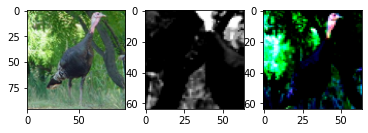

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


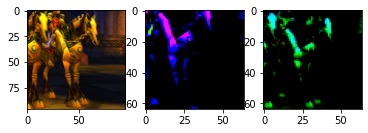

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


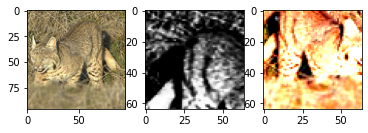

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


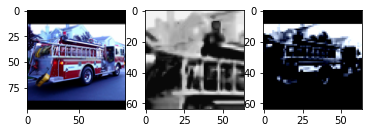

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


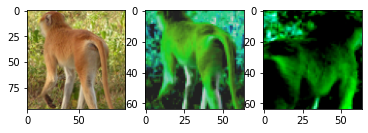

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


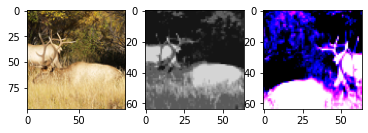

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


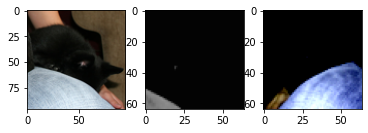

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


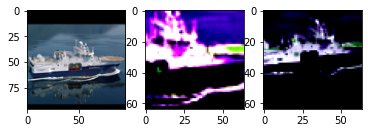

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


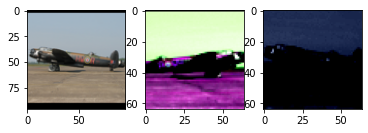

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


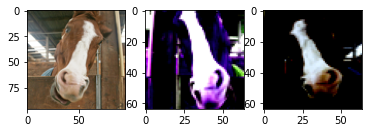

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


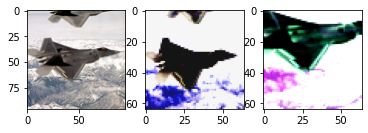

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


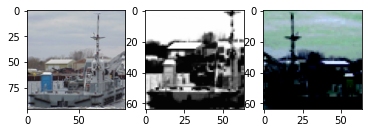

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


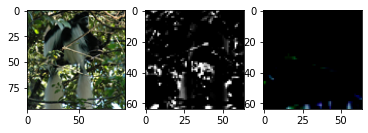

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


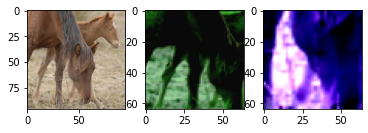

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


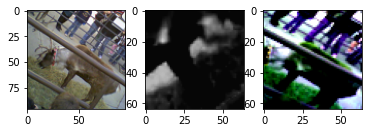

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


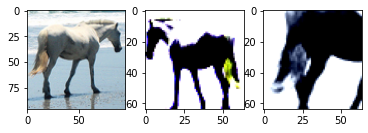

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


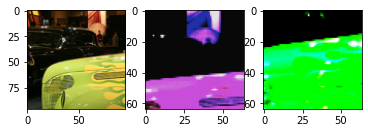

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


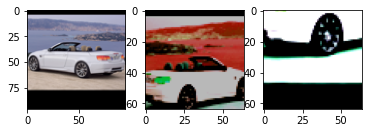

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


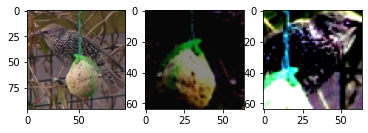

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


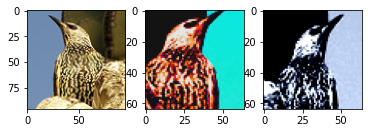

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


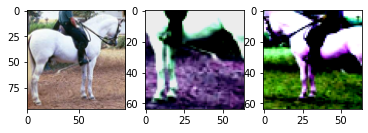

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


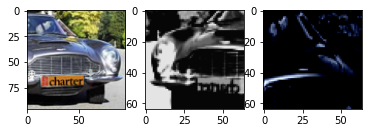

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


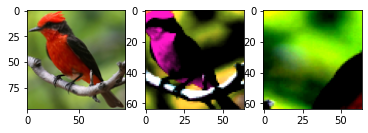

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


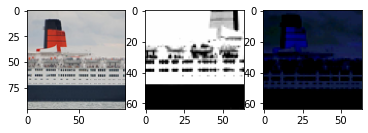

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


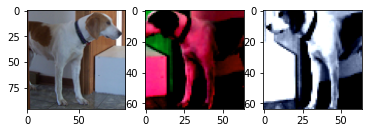

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


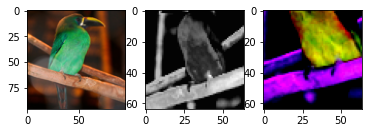

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


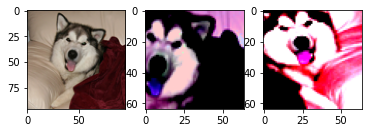

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


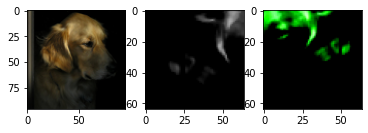

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


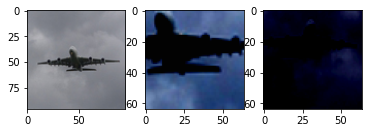

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


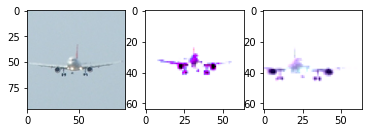

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


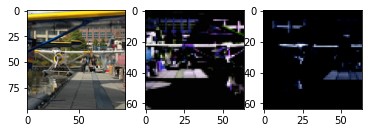

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


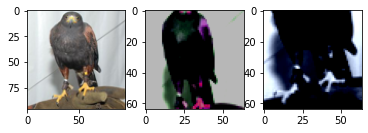

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


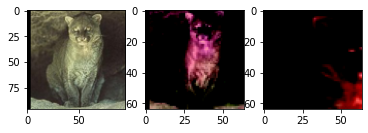

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


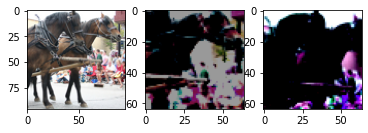

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


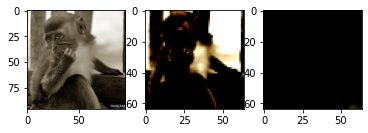

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


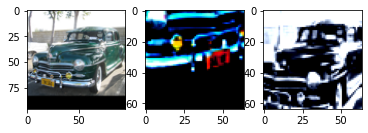

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


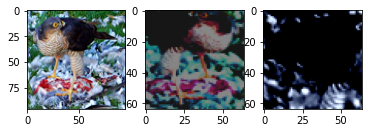

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


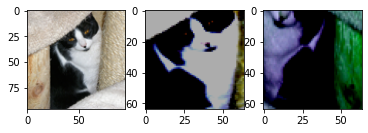

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


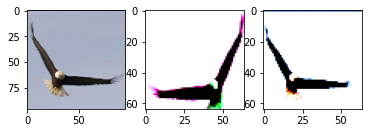

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


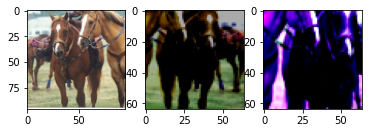

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


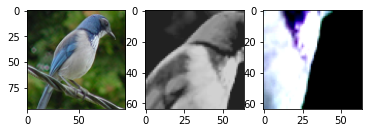

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


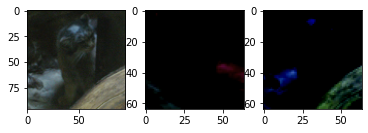

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


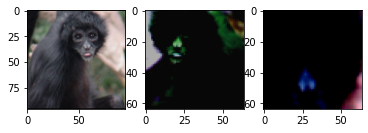

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


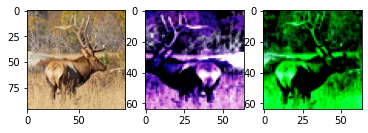

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


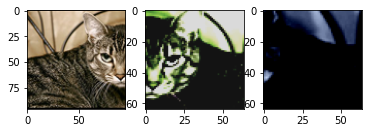

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


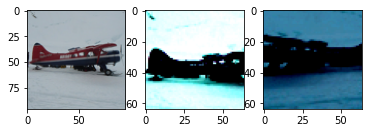

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


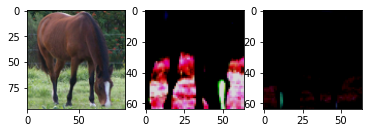

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


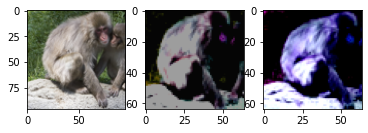

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


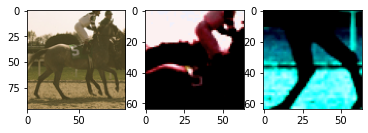

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


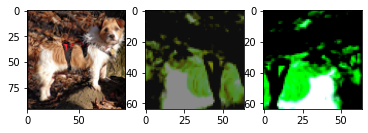

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


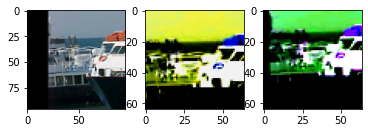

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


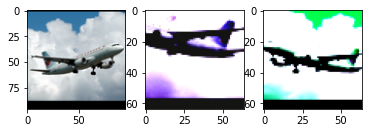

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


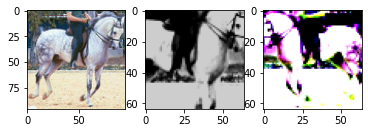

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


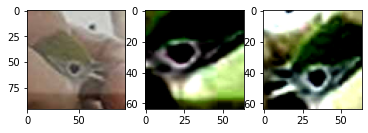

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


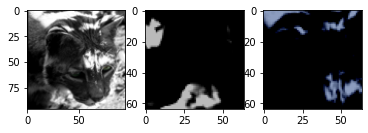

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


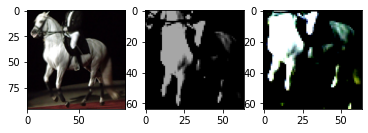

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


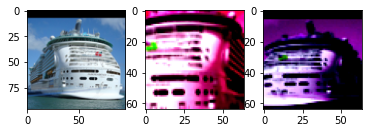

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


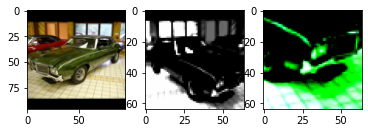

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


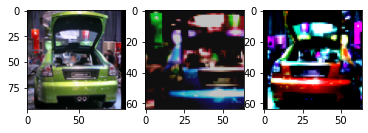

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


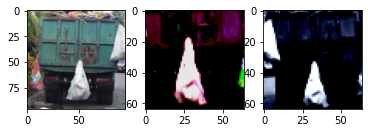

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


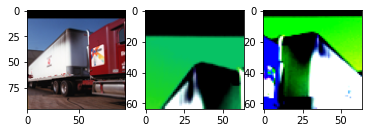

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


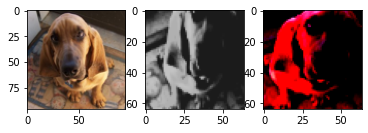

In [5]:
for i in range(64): 
    image = dataset[i][0]
    f, axarr = plt.subplots(1,3) 
    axarr[0].imshow(image)
    axarr[1].imshow(transform1(image).permute([1,2,0]))
    axarr[2].imshow(transform2(image).permute([1,2,0])) 
    plt.show()

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [7]:
opt.gpus=["cuda:1"]

In [8]:
print(f'Optimize: {opt.align_w:g} * loss_align(alpha={opt.align_alpha:g}) + {opt.unif_w:g} * loss_uniform(t={opt.unif_t:g})')

torch.cuda.set_device(opt.gpus[0])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

encoder = SmallAlexNet(feat_dim=opt.feat_dim).to(opt.gpus[0])

optim = torch.optim.SGD(encoder.parameters(), lr=opt.lr,
                        momentum=opt.momentum, weight_decay=opt.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, gamma=opt.lr_decay_rate,
                                                 milestones=opt.lr_decay_epochs)

loader_1 = get_data_loader_1(opt)
loader_2 = get_data_loader_2(opt)

align_meter = AverageMeter('align_loss')
unif_meter = AverageMeter('uniform_loss')
loss_meter = AverageMeter('total_loss')
it_time_meter = AverageMeter('iter_time')

Optimize: 1 * loss_align(alpha=2) + 1 * loss_uniform(t=2)
Files already downloaded and verified
Files already downloaded and verified


In [13]:
with torch.no_grad():
    optim.zero_grad()
    print(encoder(torch.cat([im_x.to(opt.gpus[0]), im_y.to(opt.gpus[0]), im_y.to(opt.gpus[0])])).shape)

torch.Size([192, 128])


In [10]:
for epoch in range(opt.epochs):
    align_meter.reset()
    unif_meter.reset()
    loss_meter.reset()
    it_time_meter.reset()
    t0 = time.time()
    for ii, (im_x, im_y) in enumerate(loader_1):
        optim.zero_grad()
        x, y = encoder(torch.cat([im_x.to(opt.gpus[0]), im_y.to(opt.gpus[0])])).chunk(2)
        break
        align_loss_val = align_loss(x, y, alpha=opt.align_alpha)
        unif_loss_val = (uniform_loss(x, t=opt.unif_t) + uniform_loss(y, t=opt.unif_t)) / 2
        loss = align_loss_val * opt.align_w + unif_loss_val * opt.unif_w
        align_meter.update(align_loss_val, x.shape[0])
        unif_meter.update(unif_loss_val)
        loss_meter.update(loss, x.shape[0])
        loss.backward()
        optim.step()
        it_time_meter.update(time.time() - t0)
        if ii % opt.log_interval == 0:
            print(f"Epoch {epoch}/{opt.epochs}\tIt {ii}/{len(loader)}\t" +
                  f"{align_meter}\t{unif_meter}\t{loss_meter}\t{it_time_meter}")
        t0 = time.time()
    scheduler.step()
    break

/home/hsme/miniconda3/envs/usmatching_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
encoder(torch.cat([im_x.to(opt.gpus[0]), im_y.to(opt.gpus[0])]))